In [122]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [123]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import reptrvae

In [156]:
adata = sc.read('./data/alzPro_count.h5ad')
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [276]:
adata.obs['Group'].value_counts()

HET    24
WT     24
Name: Group, dtype: int64

In [157]:
sc.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=100)
sc.pp.log1p(adata)
#sc.pp.log1p(adata, base=1000)
#sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [127]:
#adata = adata[:, adata.var['highly_variable']]

In [278]:
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    uns: 'log1p'

In [158]:
adata.X.min(), adata.X.max()

(0.0, 19.781984)

In [280]:
adata.obs['Timepoint'].value_counts()

3m    16
6m    16
9m    16
Name: Timepoint, dtype: int64

In [281]:
os.makedirs("./data/", exist_ok=True)

In [159]:
adata.write_h5ad("./data/alzPro_normalized.h5ad")

In [217]:
special_cell_type = "3m"

In [283]:
cell_type_adata = adata[adata.obs["Timepoint"] == special_cell_type]

In [284]:
cell_type_adata.obs['Group'].value_counts()

HET    8
WT     8
Name: Group, dtype: int64

In [285]:
cell_type_adata.obs['Group'].cat.categories

Index(['HET', 'WT'], dtype='object')

In [286]:
sc.tl.rank_genes_groups(cell_type_adata, groups=['HET'], groupby="Group", reference='WT', n_genes=10)

Trying to set attribute `._uns` of view, copying.


In [287]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names']['HET']
top_genes

array(['O89051|ITM2B', 'P12023|A4', 'Q9EPW0|INP4A', 'Q61207|SAP',
       'P18242|CATD', 'Q9CQ89|CUTA', 'P08226|APOE', 'O88531|PPT1',
       'P47708|RP3A', 'P30416|FKBP4'], dtype=object)

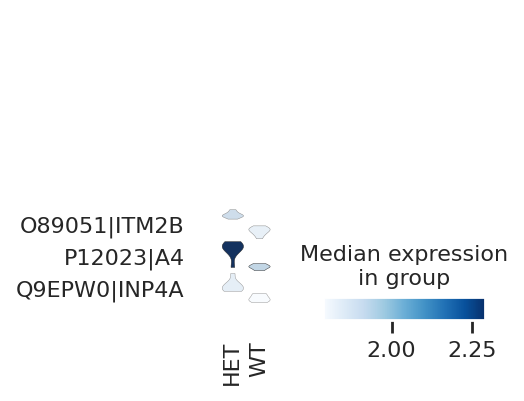

In [288]:
sc.pl.stacked_violin(cell_type_adata, groupby='Group', var_names=top_genes[:3], swap_axes=True)

## Viewing Results

In [2]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import reptrvae

Using TensorFlow backend.


In [4]:
sc.set_figure_params(dpi=200)

In [5]:
path_to_save = "./results/alzPro/"
sc.settings.figdir = path_to_save

In [6]:
specific_cell_type = "3m"

In [7]:
cell_type_key = "Timepoint"
condition_key = "Group"
target_condition = "HET"
conditions = ['WT', 'HET']

In [8]:
mode = 'normalized'
#mode = 'count'
adata = sc.read(f"./data/alzPro_{mode}.h5ad")
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'

In [9]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [10]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
cell_type_adata

View of AnnData object with n_obs × n_vars = 16 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'

In [11]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == 'WT']
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [12]:
ctrl_adata.obs['method'] = 'WT'
real_adata.obs['method'] = target_condition

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [13]:
trvae_reconstructed = sc.read(f"./data/reconstructed/trVAE_alzPro/{specific_cell_type}.h5ad")
trvae_reconstructed

AnnData object with n_obs × n_vars = 16 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'batch'

In [14]:
trvae_reconstructed.X[:8].min(), trvae_reconstructed.X[:8].max()

(4.7514606, 14.67036)

In [15]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"WT_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

In [16]:
models = ctrl_adata.concatenate(real_adata, trvae_pred)
models.obs['method'].unique()

array(['WT', 'HET', 'trVAE'], dtype=object)

In [17]:
models.var_names

Index(['A2A432|CUL4B', 'A2A699|F1712', 'A2AGT5|CKAP5', 'A2AJI0|MA7D1',
       'A2ALS5|RPGP1', 'A2RT62|FXL16', 'A6H5Z3|EXC6B', 'B0V2N1|PTPRS',
       'B1AXV0|FRS1L', 'B1AZP2|DLGP4',
       ...
       'Q9Z2I8|SUCB2', 'Q9Z2I9|SUCB1', 'Q9Z2Q6|SEPT5', 'Q9Z2U0|PSA7',
       'Q9Z2U1|PSA5', 'Q9Z2W8|GRIA4', 'Q9Z2W9|GRIA3', 'Q9Z2X1|HNRPF',
       'Q9Z2Y3|HOME1', 'Q9Z2Y8|PLPHP'],
      dtype='object', name='Accession', length=1729)

In [32]:
sc.tl.rank_genes_groups(models, reference=target_condition, 
                       groupby="method", groups=['trVAE'],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(models, reference='trVAE',
                         groupby="method", groups=[target_condition],
                         key_added='down_reg_genes', n_genes=50)
up_genes = models.uns['up_reg_genes']['names']['trVAE']
down_genes = models.uns['down_reg_genes']['names'][target_condition]

In [19]:
protein_up = up_genes[0]
print(protein_up)

P07309|TTHY


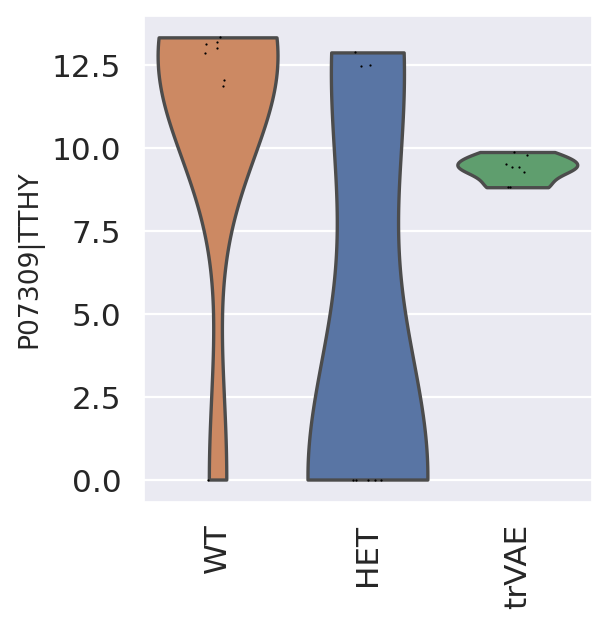

In [20]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_up, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_best_model_cmpr.pdf",
             jitter=True,
            )

In [33]:
protein_down = down_genes[0]
print(protein_down)

P35283|RAB12


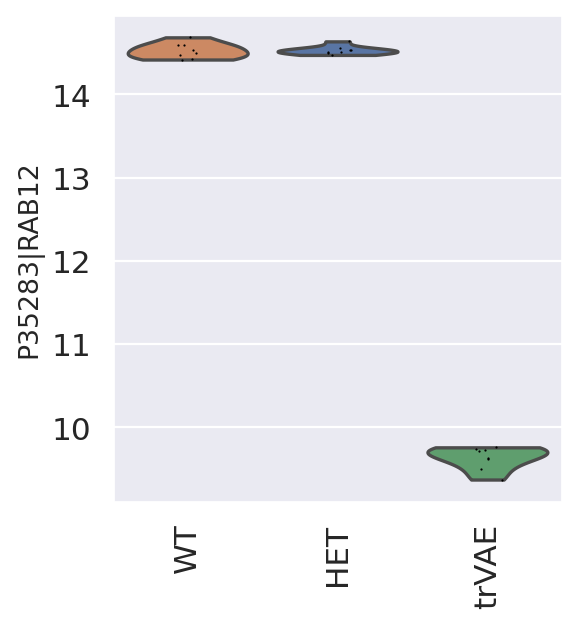

In [34]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_down, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_worst_model_cmpr.pdf",
             jitter=True,
            )

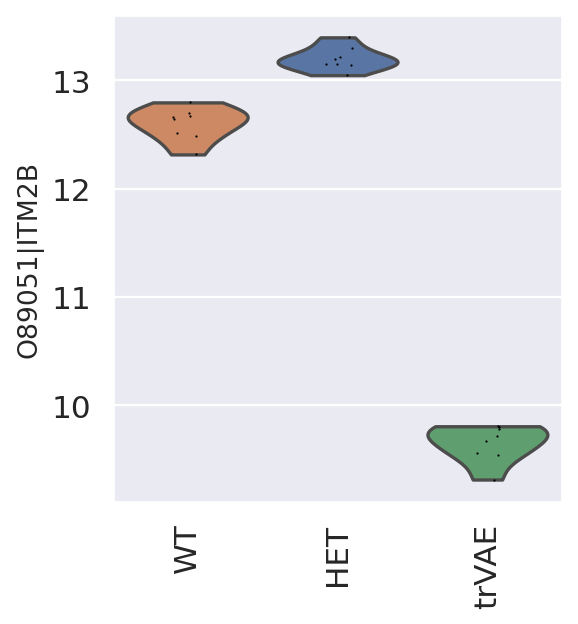

In [23]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="O89051|ITM2B", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_standard_model_cmpr.pdf",
             jitter=True,
            )

### R^2 Plots

In [24]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
adata_pred

AnnData object with n_obs × n_vars = 24 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'method', 'batch'

In [25]:
sc.tl.rank_genes_groups(cell_type_adata, reference='WT', 
                       groupby=condition_key, groups=[target_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition,
                         groupby=condition_key, groups=['WT'],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][target_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names']['WT']

Trying to set attribute `._uns` of view, copying.


In [26]:
top_genes = up_genes.tolist() + down_genes.tolist()

In [27]:
len(top_genes)

100

reg_mean_top100: 0.2068127519586208
reg_mean_all: 0.7346516493257258


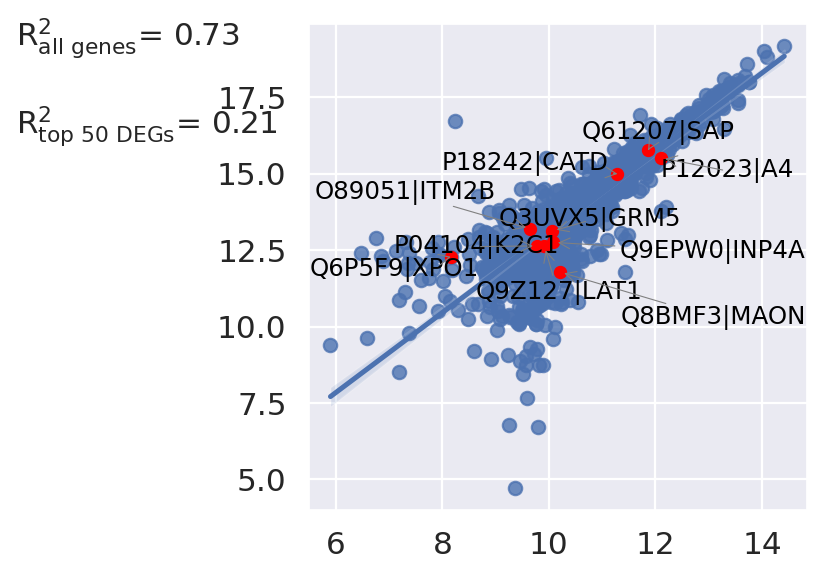

In [28]:
reptrvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.023979519185759128
reg_var_all: 0.03859975682943437


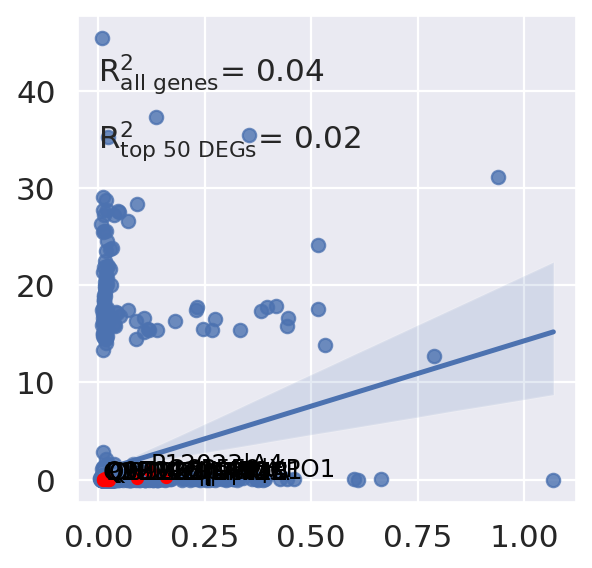

In [29]:
reptrvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

In [30]:
up_genes.tolist()

['O89051|ITM2B',
 'P12023|A4',
 'Q9EPW0|INP4A',
 'Q61207|SAP',
 'P18242|CATD',
 'Q9CQ89|CUTA',
 'P08226|APOE',
 'O88531|PPT1',
 'P47708|RP3A',
 'P30416|FKBP4',
 'Q9Z0X1|AIFM1',
 'Q9CQ22|LTOR1',
 'P10605|CATB',
 'Q8BZ98|DYN3',
 'A2AGT5|CKAP5',
 'P47857|PFKAM',
 'Q920E5|FPPS',
 'P55264|ADK',
 'P10518|HEM2',
 'Q9CPQ8|ATP5L',
 'Q91VD9|NDUS1',
 'P17751|TPIS',
 'P42669|PURA',
 'P57776|EF1D',
 'P70663|SPRL1',
 'Q99N28|CADM3',
 'P20152|VIME',
 'Q6PIE5|AT1A2',
 'Q61171|PRDX2',
 'Q3UGR5|HDHD2',
 'O88428|PAPS2',
 'Q8C0M9|ASGL1',
 'P16388|KCNA1',
 'P10649|GSTM1',
 'O35381|AN32A',
 'P56135|ATPK',
 'P60122|RUVB1',
 'Q6PA06|ATLA2',
 'P57722|PCBP3',
 'Q04447|KCRB',
 'Q9DBG6|RPN2',
 'P02802|MT1',
 'P61979|HNRPK',
 'Q80UP3|DGKZ',
 'Q08331|CALB2',
 'Q03265|ATPA',
 'P48036|ANXA5',
 'O70589|CSKP',
 'P42208|SEPT2',
 'P21619|LMNB2']

In [31]:
down_genes.tolist()

['Q8BMF3|MAON',
 'P04104|K2C1',
 'Q3UVX5|GRM5',
 'Q9Z127|LAT1',
 'Q6P5F9|XPO1',
 'Q9EQF6|DPYL5',
 'Q8VDQ8|SIR2',
 'Q9JMA1|UBP14',
 'P35803|GPM6B',
 'Q7M6Y3|PICAL',
 'P31938|MP2K1',
 'Q99LD4|CSN1',
 'Q80ZJ1|RAP2A',
 'Q62188|DPYL3',
 'O88544|CSN4',
 'P57780|ACTN4',
 'O55100|SNG1',
 'P12849|KAP1',
 'Q5PR73|DIRA2',
 'P62746|RHOB',
 'Q922Q4|P5CR2',
 'P14094|AT1B1',
 'Q922J6|TSN2',
 'P19096|FAS',
 'Q6ZPE2|MTMR5',
 'Q62418|DBNL',
 'P23818|GRIA1',
 'Q9DB15|RM12',
 'Q9DBG3|AP2B1',
 'P61205|ARF3',
 'P07309|TTHY',
 'P32037|GTR3',
 'P20444|KPCA',
 'P62482|KCAB2',
 'O08756|HCD2',
 'Q80XI4|PI42B',
 'Q99JI6|RAP1B',
 'Q91YJ2|SNX4',
 'Q9Z2I2|FKB1B',
 'P16330|CN37',
 'Q9Z0H4|CELF2',
 'Q80YN3|BCAS1',
 'Q60996|2A5G',
 'O88737|BSN',
 'Q6PEB6|PHOCN',
 'Q7TQD2|TPPP',
 'Q8BSS9|LIPA2',
 'O35465|FKBP8',
 'P68404|KPCB',
 'Q9R0P9|UCHL1']